In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy

    100% |████████████████████████████████| 1.4MB 25.4MB/s eta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/ee/80/75b684060dc6ecc5a28c07b75ef4063f378aff1a37556f342a
Successfully built python-decouple
     |████████████████████████████████| 1.5MB 3.9MB/s eta 0:00:01


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, \
    ForeignKey, Float, LargeBinary
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    prediction    = Column(LargeBinary, nullable=True)
    year          = Column(Integer, nullable=True)
    month         = Column(Integer, nullable=True)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")


class Job(BASE):
    """Job model for DB and redis. Has information on the status and result of
        redis queue job."""
    __tablename__ = 'job'
    id            = Column(BigInteger, primary_key=True)
    result        = Column(String, nullable=False)
    datetime      = Column(DateTime, nullable=False)

In [4]:
DAY_OF_WEEK  = 0
DAY_OF_MONTH = 1
HOUR_OF_DAY  = 2

data_type  = DAY_OF_WEEK

do_gridsearch = True

if data_type == DAY_OF_WEEK:
    SCALING_FACTOR = 1000.
    OPERATOR = '*'
elif data_type == DAY_OF_MONTH:
    SCALING_FACTOR = 1000.
    OPERATOR = '*'
else:
    raise ValueError("Unexpected data type:", data_type)

def scale_data(X):
    if data_type == DAY_OF_WEEK:
        X *= SCALING_FACTOR
    elif data_type == DAY_OF_MONTH:
        X *= SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        raise ValueError('Unexpected data type:', data_type)
    return X

def descale_data(X):
    if data_type == DAY_OF_WEEK:
        X /= SCALING_FACTOR
    elif data_type == DAY_OF_MONTH:
        X /= SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        raise ValueError('Unexpected data type:', data_type)
    return X

class GetData(object):
    def go(self, SESSION, start_year, end_year):
        if data_type == DAY_OF_WEEK:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        crimetype.ppo,
                        crimetype.violence,
                        COUNT(*)/AVG(block.population) AS category
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        crimetype.ppo,
                        crimetype.violence
                '''
        elif data_type == HOUR_OF_DAY:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.hour,
                        crimetype.ppo,
                        crimetype.violence,
                        COUNT(*)/AVG(block.population) AS category
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.hour,
                        crimetype.ppo,
                        crimetype.violence
                '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def fill_data(X, y, r, start_year, end_year, blockid_dict, data_type):
    
    def day_of_month(x):
        return x.day - 1

    def hour_of_day(x):
        return x.hour

    def encode(row):
        ppo_dict = {'PERSONAL': 0, 
                    'PROPERTY': 1, 
                    'OTHER': 2}
        viol_dict = {'VIOLENT': 1, 
                     'NON_VIOLENT': 0}
        res = []
        res.extend([r[0], r[1], r[2], r[3], r[4], ppo_dict[r[5]], viol_dict[r[6]], r[7]])
        
        return res
        
    # Output: blockid month dow hour ppo violence = value
    #
    #                       0  incident.blockid,
    #                       1  incident.datetime,
    #                       2  incident.year,
    #                       3  incident.month,
    #                       4  incident.dow   OR  incident.hour,
    #                       5  crimetype.ppo,     'PERSONAL', 'PROPERTY', 'OTHER'  3
    #                       6  crimetype.violence 'VIOLENT', 'NONVIOLENT'          2
    #                       7  value at this location

    r = encode(r)
    if r[2] == end_year:
        if data_type == DAY_OF_WEEK:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4], r[5], r[6]] = float(r[7])
            #                                            ^^^^        ^^^^
            #                                            dow         risk
        elif data_type == HOUR_OF_DAY:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4], r[5], r[6]] = float(r[7])
            #                                             ^^^^^^^^^^^^^^^         ^^^^
            #                                               hour of day           risk
        else:
            raise ValueError('Unsupported data type:', data_type)
    else:
        if data_type == DAY_OF_WEEK:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4], r[5], r[6]] = float(r[7])
        elif data_type == HOUR_OF_DAY:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4], r[5], r[6]] = float(r[7])
        else:
            raise ValueError('Unsupported data type:', data_type)

In [6]:
def process_data(data, start_year, end_year, blockid_dict, data_type):

    if data_type == DAY_OF_WEEK:
        X = np.zeros((len(blockid_dict), 24, 7, 3, 2))
        y = np.zeros((len(blockid_dict), 12, 7, 3, 2))
    elif data_type == HOUR_OF_DAY:
        X = np.zeros((len(blockid_dict), 24, 24, 3, 2))
        y = np.zeros((len(blockid_dict), 12, 24, 3, 2))
    else:
        raise ValueError('data_type not supported:', data_type)
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            fill_data(X, y, r, start_year, end_year, blockid_dict, data_type)

    #     print('Data value counts:', pd.Series(y.flatten()).value_counts())

    X = scale_data(X)
    y = scale_data(y)

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [7]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict,
               data_type):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict,
                                        data_type)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict,
                                      data_type)

    return X_train, X_test, y_train, y_test

## Day of week analysis for each month of each block id

In [8]:
# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 801

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

In [9]:
def plot_output(y, y_pred, dataset_type, x_label, y_label):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['data', 'prediction'], prop={'size': 20})
    plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random.seed(101)

def get_predictions(X_train, y_train, X_test, y_test, 
                    x_label, y_label, model, do_gridsearch=False):
    
    def print_data_info(data, data_name):
        flat = data.flatten()
        print('Number of data points:', len(flat))
        print('Number of non-zero elements:', len(flat[flat > 0.0]))
        print('Percentage of non-zero elements:', len(flat[flat > 0.0])/len(flat))

        pd.Series(flat).hist(bins=[0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 10, 15, 20]);
        plt.title(f'Histogram of {data_name}')
        plt.show()
    
    print_data_info(y_test, 'y_test')
    print('Correlation between y_train and y_test:\n', 
          np.corrcoef(y_train.flatten(), y_test.flatten()))
          
    def mult_of_shapes(X):
        return X.shape[1] * X.shape[2] * X.shape[3] * X.shape[4]
    
    X_train = X_train.reshape((TRAIN_NUM_BLOCKIDS, mult_of_shapes(X_train)))
    y_train = y_train.reshape((TRAIN_NUM_BLOCKIDS, mult_of_shapes(y_train)))
    X_test = X_test.reshape((TEST_NUM_BLOCKIDS, mult_of_shapes(X_test)))
    y_test = y_test.reshape((TEST_NUM_BLOCKIDS, mult_of_shapes(y_test)))

    print('y_test shape after reshaping:', y_test.shape)
    
    if do_gridsearch == True:
        # For regressors:
        param_grid = {
            'estimator__n_estimators':  [80, 100, 120],
            'estimator__max_depth': [2, 3, 4, 5, 6],
        }

        gridsearch = GridSearchCV(model,
                                  param_grid=param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1,
                                  return_train_score=True, verbose=10)
        model = gridsearch

    model.fit(X_train, y_train)

    best_training_score = model.score(X_train, y_train)
    best_testing_score  = model.score(X_test, y_test)

    print(f'  Best training score:', -best_training_score)
    print(f'  Best testing score: ', -best_testing_score)

    if do_gridsearch == True:
        best_model_params = model.cv_results_['params'][model.best_index_]
        print('Best Grid Search model:', best_model_params)

    y_pred = model.predict(X_test)
    print('mean_squared_error:', mean_squared_error(y_test, y_pred))
          
    plot_output(y_test, y_pred, 'Testing', x_label, y_label)

    def relative_percent_difference(y_true, y_pred):
        return 1 - np.absolute((y_true - y_pred) / (np.absolute(y_true) + np.absolute(y_pred)))
    
    return y_test, y_pred, relative_percent_difference(y_test, y_pred), model

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Day of week analysis for each block ID

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(801, 24, 7, 3, 2) (801, 12, 7, 3, 2) (801, 24, 7, 3, 2) (801, 12, 7, 3, 2)
Number of data points: 403704
Number of non-zero elements: 116267
Percentage of non-zero elements: 0.2880006143114757


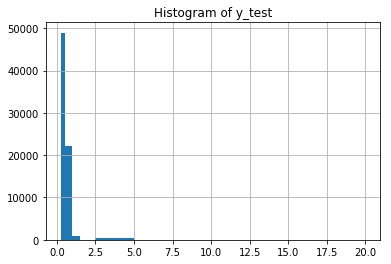

Correlation between y_train and y_test:
 [[1.         0.01015003]
 [0.01015003 1.        ]]
y_test shape after reshaping: (801, 504)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth

[Parallel(n_jobs=-1)]: Done   4 out of  45 | elapsed:  9.5min remaining: 97.2min


[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-7.460107639182985, total= 9.5min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-0.39200718105304844, total= 9.7min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-0.03379672392202941, total=10.1min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-0.3912917802130483, total=10.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-7.461859966083524, total=10.5min


[Parallel(n_jobs=-1)]: Done   9 out of  45 | elapsed: 10.5min remaining: 42.1min


[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-0.03451838913842533, total=11.2min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-7.461520876260388, total=11.5min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-0.39187426830176253, total=11.6min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-0.03358456186170497, total=12.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-0.03382013526018311, total=12.7min


[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed: 12.7min remaining: 28.2min


[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-0.391205222547138, total=12.7min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-7.462411452301225, total=12.8min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-0.3914762404814242, total=13.0min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-7.460218051717456, total=13.0min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-0.0334553666294919, total=14.7min


[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed: 14.7min remaining: 20.2min


[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-0.39116664234024096, total=14.9min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-7.463127595780331, total=14.9min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-0.03381732403183853, total=15.1min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-7.46140555845145, total=15.4min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-0.3913182964006064, total=15.5min


[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed: 15.5min remaining: 13.6min


[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-0.033554075857710156, total=15.6min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-0.3913511513284288, total=15.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-7.4607611578616035, total=15.9min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-0.03342327957345924, total=16.7min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-7.463534582695205, total=16.8min


[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed: 16.9min remaining:  9.3min


[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-0.39125849039308896, total=16.9min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-0.03344840490675677, total=18.2min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-7.461279754424027, total=18.6min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-0.3913508801519454, total=18.6min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-0.033579107763697436, total=18.6min


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed: 18.7min remaining:  6.0min


[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-0.3912211454699524, total=19.0min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-7.4619588510714, total=19.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-0.03338264827155778, total=20.6min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-7.461703283503674, total=20.9min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-0.3914222458089877, total=21.0min


[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed: 21.0min remaining:  3.2min


[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-0.03343767630709199, total=21.7min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-7.4624736947563175, total=22.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-0.3911830129047798, total=22.1min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-0.03339904751755577, total=24.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-7.4631555880758444, total=24.8min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-0.3912115230455779, total=24.9min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 24.9min finished


  Best training score: 0.32703810207044026
  Best testing score:  0.841507379733998
Best Grid Search model: {'estimator__max_depth': 3, 'estimator__n_estimators': 100}
mean_squared_error: 0.841507379733998


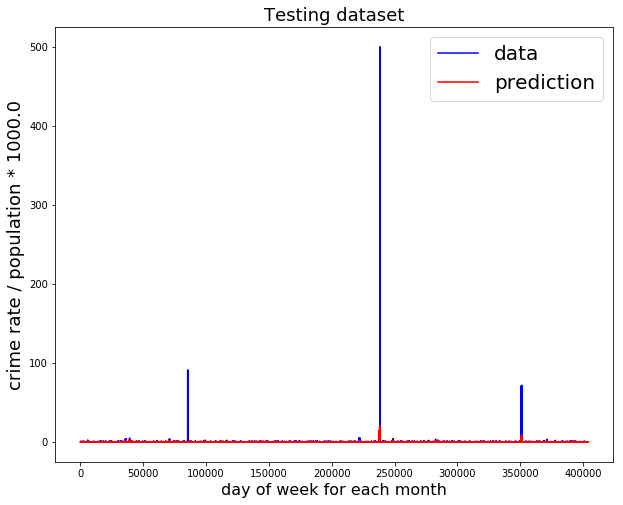

CPU times: user 19min 42s, sys: 14.9 s, total: 19min 57s
Wall time: 45min 13s


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in true_divide


In [11]:
%%time

X_train_dow, X_test_dow, y_train_dow, y_test_dow = \
        ready_data(2015, 2017, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   DAY_OF_WEEK)

print(X_train_dow.shape, y_train_dow.shape, X_test_dow.shape, y_test_dow.shape)
model = MultiOutputRegressor(RandomForestRegressor())
y_test_dow, y_pred_dow, rpd_dow, model_dow = \
    get_predictions(X_train_dow, y_train_dow, X_test_dow, y_test_dow, 
                    'day of week for each month', 
                    f'crime rate / population {OPERATOR} {SCALING_FACTOR}', 
                    model, do_gridsearch=do_gridsearch)

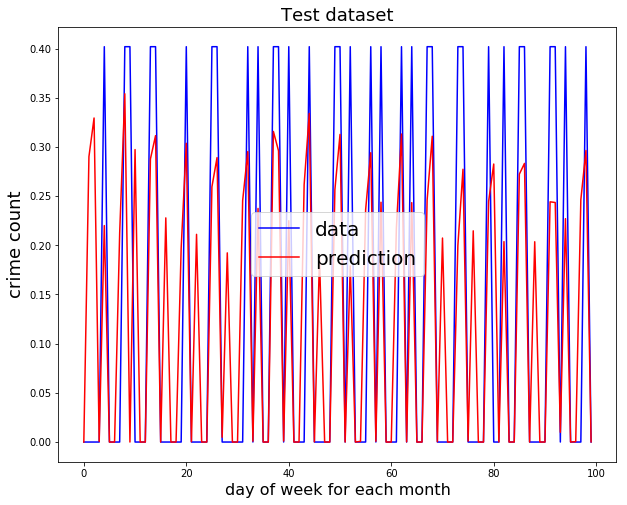

In [12]:
plot_output(y_test_dow.flatten()[:100], y_pred_dow.flatten()[:100], 'Test', 
            'day of week for each month', 'crime count')

## Hour of day analysis for each block ID

(801, 24, 24, 3, 2) (801, 12, 24, 3, 2) (801, 24, 24, 3, 2) (801, 12, 24, 3, 2)
Number of data points: 1384128
Number of non-zero elements: 116267
Percentage of non-zero elements: 0.08400017917418043


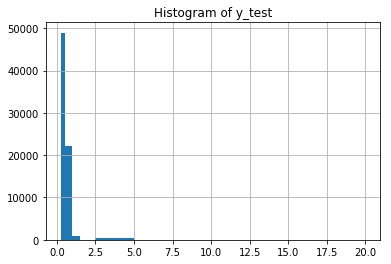

Correlation between y_train and y_test:
 [[1.         0.01582655]
 [0.01582655 1.        ]]
y_test shape after reshaping: (801, 1728)
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=100 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=2, estimator__n_estimators=120 .............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_depth=3, estimator__n_estimators=80 ..............
[CV] estimator__max_dept

[Parallel(n_jobs=-1)]: Done   4 out of  45 | elapsed: 15.9min remaining: 163.2min


[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-2.176342468509087, total=16.1min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-0.010049593649109569, total=17.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=80, score=-0.11425990686171875, total=17.8min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-2.1759671578950206, total=17.9min
[CV]  estimator__max_depth=2, estimator__n_estimators=100, score=-0.11433336716365276, total=17.9min


[Parallel(n_jobs=-1)]: Done   9 out of  45 | elapsed: 18.2min remaining: 72.6min


[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-0.11423270697617298, total=18.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-0.00982135842011772, total=19.6min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-0.009853166722351881, total=19.8min
[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-0.11418578526105193, total=19.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=80, score=-2.17651763545285, total=20.0min


[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed: 20.2min remaining: 44.7min


[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-0.00976936365020431, total=20.6min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-2.176657029217431, total=21.0min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-0.11435527788600895, total=21.1min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-0.010076143647463296, total=21.3min
[CV]  estimator__max_depth=2, estimator__n_estimators=120, score=-2.176027570630207, total=21.5min


[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed: 21.7min remaining: 29.7min


[CV]  estimator__max_depth=3, estimator__n_estimators=100, score=-2.1760257289420277, total=21.6min
[CV]  estimator__max_depth=5, estimator__n_estimators=80, score=-0.11423314372024217, total=22.3min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-0.009760302328289526, total=22.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-2.1761716694264512, total=23.0min
[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-2.1768400166111097, total=23.2min


[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed: 23.3min remaining: 20.4min


[CV]  estimator__max_depth=6, estimator__n_estimators=80, score=-0.11424698166739355, total=23.2min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-0.009775611480396651, total=23.4min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-0.009866250740556269, total=23.5min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-2.1760204116020665, total=23.6min
[CV]  estimator__max_depth=4, estimator__n_estimators=100, score=-0.11416008671087734, total=24.3min


[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed: 24.5min remaining: 13.5min


[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-0.009736480651129488, total=25.2min
[CV]  estimator__max_depth=3, estimator__n_estimators=120, score=-0.11421268500370113, total=25.3min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-2.1763467272611154, total=25.8min
[CV]  estimator__max_depth=5, estimator__n_estimators=100, score=-0.11415651076292026, total=25.8min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-0.11416699608920233, total=27.0min


[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed: 27.2min remaining:  8.8min


[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-0.009734432683537646, total=27.9min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-0.009791274762431398, total=28.2min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-0.11417531613759703, total=28.4min
[CV]  estimator__max_depth=4, estimator__n_estimators=120, score=-2.176228644140617, total=28.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=100, score=-2.176455937389994, total=28.5min


[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed: 28.7min remaining:  4.4min


[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-0.009746210875079996, total=30.1min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-0.11416194777972458, total=30.3min
[CV]  estimator__max_depth=5, estimator__n_estimators=120, score=-2.1763983104954305, total=30.5min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-0.009739183538694494, total=33.9min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-2.1764862536609915, total=34.1min
[CV]  estimator__max_depth=6, estimator__n_estimators=120, score=-0.11418428353584159, total=34.5min


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 34.7min finished


  Best training score: 0.1054031754402154
  Best testing score:  0.24654359914174068
Best Grid Search model: {'estimator__max_depth': 3, 'estimator__n_estimators': 100}
mean_squared_error: 0.24654359914174068


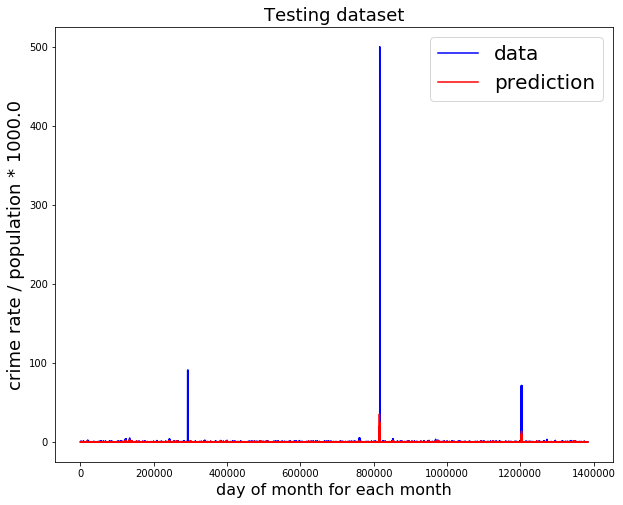

CPU times: user 26min 5s, sys: 14 s, total: 26min 19s
Wall time: 1h 2min 13s


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
%%time

X_train_hod, X_test_hod, y_train_hod, y_test_hod = \
    ready_data(2015, 2017, train_blockid_dict,
               X_test_start_year, X_test_end_year, test_blockid_dict,
               HOUR_OF_DAY)

print(X_train_hod.shape, y_train_hod.shape, X_test_hod.shape, y_test_hod.shape)

model = MultiOutputRegressor(RandomForestRegressor())

y_test_hod, y_pred_hod, rpd_hod, model_hod = \
    get_predictions(X_train_hod, y_train_hod, X_test_hod, y_test_hod, 
                    'day of month for each month', 
                    f'crime rate / population {OPERATOR} {SCALING_FACTOR}', 
                    model, do_gridsearch=do_gridsearch)

In [ ]:
# # Save predictions to files
# y_dow = y_pred_dow.copy(order='C')
# y_hod = y_pred_hod.copy(order='C')
# with open('crime_rates_dow.pred', 'wb') as f:
#     f.write(y_dow)
# with open('crime_rates_hod.pred', 'wb') as f:
#     f.write(y_hod)

## Weigh and combine predictions into one array

In [ ]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

crime_rate = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK, NUM_HOURS_IN_DAY, 3, 2))
y_test_dow_times_hour = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK, NUM_HOURS_IN_DAY, 3, 2))

# Each of the relative percent difference arrays can contain NaN's.
# This is because if both y_pred and y_true were zeros, their
# addition is also zero, and we cannot divide by this zero.
# Here we replace NaN's to get around that issue.
# Since we want to have the highest weight to those values that
# have the same y_pred and y_true, we will give the largest value
# from our array to these NaNs.

rpd_dow = np.nan_to_num(rpd_dow)
rpd_hod = np.nan_to_num(rpd_hod)

print('Number of nans after replacement:', np.isnan(rpd_dow).sum())

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

# for blockid in range(NUM_BLOCKIDS):
#     count = np.zeros((NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK, NUM_HOURS_IN_DAY, 3, 2))
    
#     for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        
#         for day in range(1, days_in_month(end_year, month) + 1):
#             for hour in range(24):
#                 dow  = day_of_week(datetime(end_year, month, day))

#                 weight_dow = rpd_dow[blockid, (month - 1)*dow]
#                 weight_hod = rpd_hod[blockid, (month - 1)*hour]
#                 weight_sum = weight_dow + weight_hod
                
#                 crime_rate[blockid, month-1, dow * hour] += \
#                     (y_pred_dow[blockid, (month - 1)*dow] * weight_dow +
#                      y_pred_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                
#                 y_test_dow_times_hour[blockid, month-1, dow*hour] += \
#                     (y_test_dow[blockid, (month - 1)*dow] * weight_dow +
#                      y_test_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                
#                 count[dow * hour] += 1
#         crime_rate[blockid, month-1, dow * hour] /= count[dow * hour]
#         y_test_dow_times_hour[blockid, month-1, dow * hour] /= count[dow * hour]


for i in range(NUM_DAYS_IN_WEEK):
    for j in range(NUM_HOURS_IN_DAY):
        crime_rate[:, :, i, j, :, :] = \
            (y_pred_dow[:, :, i, :, :] * rpd_dow[:, :, i, :, :] + y_pred_hod[:, :, j, :, :] * rpd_hod[:, :, j, :, :]) / \
            (rpd_dow[:, :, i, :, :] + rpd_hod[:, :, j, :, :])
        y_test_dow_times_hour[:, :, i, j, :, :] = \
            (y_test_dow[:, :, i, :, :] * rpd_dow[:, :, i, :, :] + y_test_hod[:, :, j, :, :] * rpd_hod[:, :, j, :, :]) / \
            (rpd_dow[:, :, i, :, :] + rpd_hod[:, :, j, :, :])


crime_rate_descaled = descale_data(crime_rate)
crime_rate_descaled = np.nan_to_num(crime_rate_descaled)
crime_rate = crime_rate_descaled.copy()
y_test_dow_times_hour = descale_data(y_test_dow_times_hour)
y_test_dow_times_hour = np.nan_to_num(y_test_dow_times_hour)

Number of nans after replacement: 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
y = y_test_dow_times_hour.flatten()
r = crime_rate.flatten()
print('Number of zeros in y_test_dow_times_hour:', len(y[y == 0.0]), 'out of:', len(y))
print('Number of zeros in risks:', len(r[r == 0.0]), 'out of:', len(r))

Number of zeros in y_test_dow_times_hour: 1364772 out of: 1614816
Number of zeros in risks: 1364772 out of: 1614816


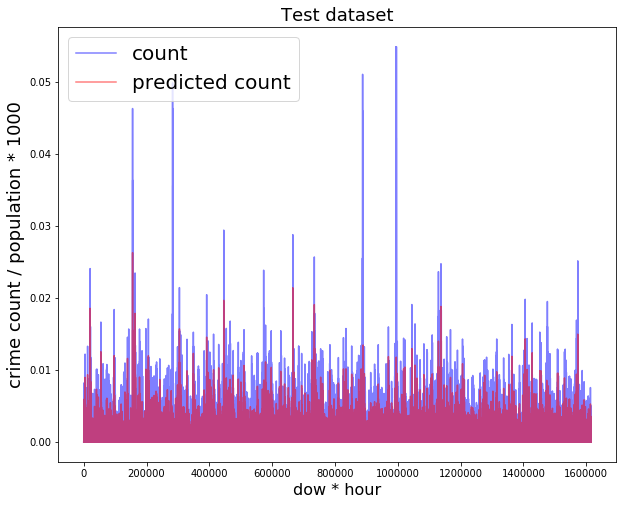

In [ ]:
def plot_y_vs_ypred(y, y_pred):
    fig = plt.figure(figsize=(10, 8))

    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue', alpha=0.5);
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red', alpha=0.5);
    plt.xlabel('dow * hour', fontsize=16)
    plt.ylabel('crime count / population * 1000', fontsize=18)
    plt.title('Test dataset', fontsize=18)
    if data_type == DAY_OF_WEEK:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    elif data_type == HOUR_OF_DAY:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    else:
        plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()
plot_y_vs_ypred(y_test_dow_times_hour, crime_rate)

In [ ]:
print('Correlation between y_test and y_pred',
          np.corrcoef(y_test_dow_times_hour.flatten(), crime_rate.flatten()))

Correlation between y_test and y_pred [[1.         0.94046495]
 [0.94046495 1.        ]]


## Store predictions in DB

In [23]:
import pickle

# Best Grid Search model: {'estimator__max_depth': 4, 'estimator__n_estimators': 120}
#
with open("predictions_working_week5_wednesday_model_dow", "wb") as f:
    pickle.dump(model_dow, f)
 
# Best Grid Search model: {'estimator__max_depth': 3, 'estimator__n_estimators': 120}
#
with open("predictions_working_week5_wednesday_model_hod", "wb") as f:
    pickle.dump(model_hod, f)

with open('predictions_working_week5_wednesday_crime_rates_dow.pred', 'wb') as f:
    f.write(y_dow)

with open('predictions_working_week5_wednesday_crime_rates_hod.pred', 'wb') as f:
    f.write(y_hod)
    
with open("predictions_working_week5_wednesday_test_blockid_dict.pkl", "wb") as f:
    pickle.dump(test_blockid_dict, f)

with open("predictions_working_week5_wednesday_crime_rate.pkl", "wb") as f:
    pickle.dump(crime_rate, f)

In [ ]:
from decouple import config

pred_blockid_dict = test_blockid_dict
def store_predictions_in_db(y_pred):
    
    DB_URI_WRITE  = config('DB_URI_WRITE')

    # Put predictions into pandas DataFrame with corresponding block id
    predictions = pd.DataFrame([[x] for x in pred_blockid_dict.keys()], columns=["id"])

    predictions.loc[:, "prediction"] = predictions["id"].apply(lambda x: y_pred[pred_blockid_dict[x],:,:].astype(np.float64).tobytes().hex())
    predictions.loc[:, "month"] = 0
    predictions.loc[:, "year"] = 2018
    predictions.to_csv("predictions.csv", index=False)

    # Query SQL
    query_commit_predictions = """
    CREATE TEMPORARY TABLE temp_predictions (
        id SERIAL PRIMARY KEY,
        prediction TEXT,
        month INTEGER,
        year INTEGER
    );

    COPY temp_predictions (id, prediction, month, year) FROM STDIN DELIMITER ',' CSV HEADER;

    UPDATE block
    SET 
        prediction = DECODE(temp_predictions.prediction, 'hex'),
        month = temp_predictions.month,
        year = temp_predictions.year 
    FROM temp_predictions
    WHERE block.id = temp_predictions.id;

    DROP TABLE temp_predictions;
    """

    # Open saved predictions and send to database using above query
    with open("predictions.csv", "r") as f:
        print("SENDING TO DB")
        RAW_CONN = create_engine(DB_URI_WRITE).raw_connection()
        cursor = RAW_CONN.cursor()
        cursor.copy_expert(query_commit_predictions, f)
        RAW_CONN.commit()
        RAW_CONN.close()

    for r in SESSION.execute("SELECT ENCODE(prediction::BYTEA, 'hex'), id FROM block WHERE prediction IS NOT NULL LIMIT 5;").fetchall():
        print(np.frombuffer(bytes.fromhex(r[0]), dtype=np.float64).reshape((12,7,24)))
        print(y_pred[pred_blockid_dict[int(r[1])], :].reshape((12,7,24)))

In [ ]:
with session_scope() as SESSION:
    store_predictions_in_db(crime_rate)

SENDING TO DB
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.93569623e-03 5.30950996e-04 1.72427332e-03 ... 0.00000000e+00
   1.01732097e-03 1.83587111e-04]
  [2.11203555e-03 0.00000000e+00 1.06244723e-03 ... 0.00000000e+00
   1.16489919e-04 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.92877946e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e